<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [1]:
student_number = '400104929'
first_name = 'Taraneh'
last_name = 'Khosrojerdi'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [1]:
# TODO: Write your code here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable. 

In [2]:
# TODO: Write your code here
data = pd.read_csv('./Data/satimage.csv')
features = data.drop('label', axis=1)
labels = data['label']

Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [3]:
# TODO: Write your code here
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.625, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [4]:
# TODO: Write your code here
complete_X_train = X_train.copy()
complete_y_train = y_train.copy()
complete_X_val = X_val.copy()
complete_y_val = y_val.copy()
complete_X_test = X_test.copy()
complete_y_test = y_test.copy()

train_mask = np.logical_or(y_train == 4, y_train == 6)
X_train = X_train[train_mask]
y_train = y_train[train_mask]

val_mask = np.logical_or(y_val == 4, y_val == 6)
X_val = X_val[val_mask]
y_val = y_val[val_mask]

test_mask = np.logical_or(y_test == 4, y_test == 6)
X_test = X_test[test_mask]
y_test = y_test[test_mask]

y_train[y_train == 4] = 1
y_train[y_train == 6] = -1

y_val[y_val == 4] = 1
y_val[y_val == 6] = -1

y_test[y_test == 4] = 1
y_test[y_test == 6] = -1


# Model (50 points)

Here is soft margin svm convex optimization formulation. 
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

`TODO: Write Here`
$$
\begin{aligned}
\text { Maximize } & \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i\alpha_j y_i y_j {x_i}^T x_j\\
\text { Subject to } & \sum_{i=1}^{N}\alpha_iy_i = 0 \quad \text{and} \quad 0 \leq \alpha_i \leq C \quad \text{for } i=1,2,...,N

\end{aligned}
$$

Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [5]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectors: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    n_samples, n_features = X.shape

    y = np.array(y).reshape(-1, 1)

    K = np.dot(X, X.T)
    P = matrix((np.outer(y, y) * K).astype(float))

    q = matrix((-np.ones((n_samples, 1))).astype(float))
    G = matrix((np.vstack((np.eye(n_samples) * (-1), np.eye(n_samples)))).astype(float))
    h = matrix((np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))).astype(float))
    A = matrix((y.reshape(1, -1)).astype(float))
    b = matrix(np.array([0.0]))

    solution = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(solution['x'])
    sv = (alphas > 1e-4).flatten()

    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas


In [6]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.1265e+02 -3.3971e+03  2e+04  3e+00  2e-13
 1: -4.1824e+02 -2.2816e+03  3e+03  3e-01  1e-13
 2: -3.9732e+02 -7.6474e+02  4e+02  3e-02  9e-14
 3: -4.4111e+02 -5.8227e+02  2e+02  9e-03  9e-14
 4: -4.6125e+02 -5.3708e+02  8e+01  4e-03  9e-14
 5: -4.7293e+02 -5.1305e+02  4e+01  2e-03  9e-14
 6: -4.7763e+02 -5.0407e+02  3e+01  1e-03  9e-14
 7: -4.8272e+02 -4.9477e+02  1e+01  4e-04  1e-13
 8: -4.8534e+02 -4.9054e+02  5e+00  2e-04  1e-13
 9: -4.8671e+02 -4.8840e+02  2e+00  4e-05  1e-13
10: -4.8718e+02 -4.8773e+02  6e-01  7e-06  1e-13
11: -4.8738e+02 -4.8747e+02  9e-02  4e-07  1e-13
12: -4.8742e+02 -4.8743e+02  7e-03  3e-08  1e-13
13: -4.8742e+02 -4.8742e+02  2e-04  6e-10  1e-13
Optimal solution found.


In [7]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas, C=1, gamma=1):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    output:
        y_pred: predictoin labels
    """
    
    # TODO: Write your code here
    support_vectors = np.array(support_vectors)
    N = len(support_vector_alphas)
    
    w = sum(support_vector_alphas[i] * support_vector_labels[i] * support_vectors[i] for i in range(N))
    
    sample = None
    for i, s in enumerate(support_vectors):
        if 0 < support_vector_alphas[i] < C:
            sample = (i, s)
            break
    
    w0 = (1 / support_vector_labels[sample[0]]) - (np.dot(w, sample[1]))
    
    y_pred = []
    x_test = np.array(x_test)
    for x in x_test:
        prediction = w0 + np.dot(w, x)
        y_pred.append(np.sign(prediction))
    
    return y_pred
        

In [8]:
y_pred = predict_labels(X_test, support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [10]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    # TODO: Write your code here

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    
    return accuracy, balanced_accuracy, confusion_mat


_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7565055762081785
Balanced Accuracy:  0.8136191358544597
Confusion Matrix:
 [[260 123]
 [  8 147]]


<Axes: >

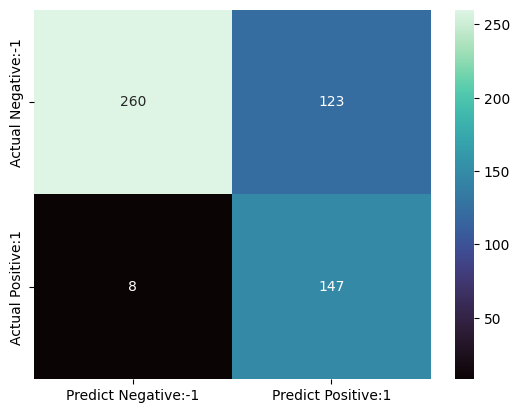

In [11]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [11]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    output = np.exp(-gamma * np.dot((x1 - x2), (x1 - x2)))
    return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    # TODO: Write your code here

    n_samples, n_features = X.shape

    y = np.array(y).reshape(-1, 1)

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf(X[i], X[j], gamma)

    P = matrix((np.outer(y, y) * K).astype(float))

    q = matrix((-np.ones((n_samples, 1))).astype(float))
    G = matrix((np.vstack((np.eye(n_samples) * (-1), np.eye(n_samples)))).astype(float))
    h = matrix((np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))).astype(float))
    A = matrix((y.reshape(1, -1)).astype(float))
    b = matrix(np.array([0.0]))

    solution = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(solution['x'])
    sv = (alphas > 1e-4).flatten()

    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [12]:
gammas = [0.01, 0.1, 1, 10, 100]
best_gamma = None
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

# TODO: Write your code here
best_balanced_accuracy = -1
for gamma in gammas:
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C, gamma)
    y_val_pred = predict_labels(X_val, support_vectors, support_vector_labels, support_vector_alphas, C, gamma)
    balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    if balanced_accuracy > best_balanced_accuracy:
        best_balanced_accuracy = balanced_accuracy
        best_gamma = gamma
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas

print(best_gamma)

     pcost       dcost       gap    pres   dres
 0: -5.7870e+02 -3.1897e+03  2e+04  3e+00  1e-14
 1: -4.0863e+02 -2.0634e+03  2e+03  2e-01  1e-14
 2: -4.2109e+02 -6.8997e+02  3e+02  2e-02  9e-15
 3: -4.6476e+02 -5.9584e+02  1e+02  8e-03  9e-15
 4: -4.8769e+02 -5.5091e+02  7e+01  3e-03  9e-15
 5: -4.9596e+02 -5.3660e+02  4e+01  2e-03  9e-15
 6: -5.0371e+02 -5.2370e+02  2e+01  8e-04  9e-15
 7: -5.0860e+02 -5.1604e+02  8e+00  2e-04  1e-14
 8: -5.1083e+02 -5.1270e+02  2e+00  4e-05  1e-14
 9: -5.1160e+02 -5.1168e+02  8e-02  4e-07  1e-14
10: -5.1164e+02 -5.1164e+02  6e-03  1e-08  1e-14
11: -5.1164e+02 -5.1164e+02  3e-04  6e-10  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5478e+02 -2.9645e+03  1e+04  3e+00  4e-15
 1: -2.5774e+02 -1.8143e+03  2e+03  1e-01  4e-15
 2: -2.7515e+02 -5.5668e+02  3e+02  2e-02  3e-15
 3: -3.1035e+02 -4.0746e+02  1e+02  5e-03  3e-15
 4: -3.2161e+02 -3.7676e+02  6e+01  2e-03  3e-15
 5: -3.3186e+02 -3.4879e+02  2e+01  3e-04  4e-1

In [14]:
y_pred = predict_labels(np.array(X_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8066914498141264
Balanced Accuracy:  0.7432493893708414
Confusion Matrix:
 [[342  41]
 [ 63  92]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]
# TODO: Write your code here

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(complete_X_train, complete_y_train)

best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

print("Best C:", best_C)
print("Best Gamma:", best_gamma)

best_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_model.fit(complete_X_train, complete_y_train)

y_test_pred = best_model.predict(complete_X_test)
_, _, confusion_mat = evaluate(complete_y_test, y_test_pred)

Best C: 10
Best Gamma: 0.1
Accuracy:  0.9092604101926662
Balanced Accuracy:  0.8880046622293033
Confusion Matrix:
 [[352   0   1   0   2   0]
 [  0 183   1   0   3   2]
 [  3   0 322  12   0   5]
 [  3   4  31  94   3  20]
 [  1   1   1   1 173   8]
 [  0   0   8  31   5 339]]


In [20]:
def decision_function(x_test, support_vectors, support_vector_labels, support_vector_alphas, C=10, gamma=0.1):
    support_vectors = np.array(support_vectors)
    w0 = 0
    for i, alpha in enumerate(support_vector_alphas):
        w0 += alpha * support_vector_labels[i] * rbf(x_test, support_vectors[i], gamma)
    score = w0
    
    return score 

Implement Multiclass SVM from scratch without using ready functions (optional).

In [21]:
from tqdm import tqdm

unique_classes = np.unique(complete_y_train)
label_vector_values = {}
for i, label in enumerate(tqdm(unique_classes)):
    converted_y_train = np.where(complete_y_train == label, 1, -1)
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(complete_X_train, converted_y_train)
    label_vector_values[label] = (support_vectors, support_vector_labels, support_vector_alphas)
    
predictions = []

for i, x in enumerate(tqdm(complete_X_test)):
    scores = {}
    for label in unique_classes:
        support_vectors, support_vector_labels, support_vector_alphas = label_vector_values[label]
        score = decision_function(x, support_vectors, support_vector_labels, support_vector_alphas)
        scores[label] = score
        
    predictions.append(max(scores, key=scores.get))

_, _, cm = evaluate(complete_y_test, predictions)


  0%|          | 0/6 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0:  1.3434e+03 -1.0449e+05  2e+05  3e-01  8e-15
 1:  1.3725e+03 -1.3580e+04  2e+04  2e-02  9e-15
 2:  5.0412e+02 -4.4235e+03  6e+03  5e-03  9e-15
 3:  7.6926e+01 -1.7462e+03  2e+03  1e-03  7e-15
 4: -9.0500e+01 -9.4622e+02  9e+02  5e-04  6e-15
 5: -1.6939e+02 -5.8260e+02  4e+02  2e-04  5e-15
 6: -2.0848e+02 -4.1907e+02  2e+02  1e-15  6e-15
 7: -2.3130e+02 -3.3288e+02  1e+02  8e-15  5e-15
 8: -2.4420e+02 -2.9045e+02  5e+01  2e-14  6e-15
 9: -2.5248e+02 -2.6703e+02  1e+01  2e-14  6e-15
10: -2.5482e+02 -2.6158e+02  7e+00  1e-14  6e-15
11: -2.5606e+02 -2.5896e+02  3e+00  1e-14  7e-15
12: -2.5629e+02 -2.5859e+02  2e+00  6e-15  6e-15
13: -2.5690e+02 -2.5765e+02  8e-01  2e-14  6e-15
14: -2.5714e+02 -2.5729e+02  1e-01  2e-14  6e-15
15: -2.5720e+02 -2.5722e+02  2e-02  1e-15  6e-15
16: -2.5721e+02 -2.5721e+02  2e-03  2e-14  6e-15


 17%|█▋        | 1/6 [03:43<18:35, 223.09s/it]

17: -2.5721e+02 -2.5721e+02  5e-05  6e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6219e+03 -8.0317e+04  2e+05  3e-01  5e-15
 1:  1.1623e+03 -7.4002e+03  1e+04  1e-02  5e-15
 2:  4.0985e+02 -2.1897e+03  3e+03  2e-03  6e-15
 3:  1.1872e+02 -9.6418e+02  1e+03  6e-04  5e-15
 4: -2.5176e+01 -3.6451e+02  3e+02  1e-05  4e-15
 5: -6.5955e+01 -2.0596e+02  1e+02  4e-06  3e-15
 6: -8.4316e+01 -1.3332e+02  5e+01  4e-07  2e-15
 7: -9.0268e+01 -1.1296e+02  2e+01  3e-15  2e-15
 8: -9.2454e+01 -1.0598e+02  1e+01  5e-15  2e-15
 9: -9.4368e+01 -9.9923e+01  6e+00  2e-15  2e-15
10: -9.5246e+01 -9.7643e+01  2e+00  5e-15  2e-15
11: -9.5738e+01 -9.6636e+01  9e-01  7e-15  2e-15
12: -9.5954e+01 -9.6264e+01  3e-01  1e-14  2e-15
13: -9.6073e+01 -9.6100e+01  3e-02  2e-14  2e-15
14: -9.6085e+01 -9.6086e+01  6e-04  1e-14  2e-15


 33%|███▎      | 2/6 [08:11<16:39, 249.98s/it]

15: -9.6085e+01 -9.6085e+01  8e-06  3e-15  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3593e+01 -1.1422e+05  2e+05  3e-01  2e-14
 1: -5.7687e+01 -1.8173e+04  2e+04  2e-02  2e-14
 2: -6.6421e+02 -8.1634e+03  9e+03  6e-03  2e-14
 3: -1.0038e+03 -5.5445e+03  5e+03  3e-03  2e-14
 4: -1.3221e+03 -3.6305e+03  2e+03  1e-03  2e-14
 5: -1.5853e+03 -2.4129e+03  8e+02  2e-04  3e-14
 6: -1.7090e+03 -1.9935e+03  3e+02  3e-05  3e-14
 7: -1.7522e+03 -1.8633e+03  1e+02  8e-06  3e-14
 8: -1.7659e+03 -1.8218e+03  6e+01  2e-14  3e-14
 9: -1.7760e+03 -1.7962e+03  2e+01  3e-14  3e-14
10: -1.7798e+03 -1.7873e+03  7e+00  3e-14  3e-14
11: -1.7816e+03 -1.7837e+03  2e+00  4e-15  3e-14
12: -1.7821e+03 -1.7828e+03  8e-01  3e-14  3e-14
13: -1.7823e+03 -1.7826e+03  3e-01  8e-15  3e-14
14: -1.7824e+03 -1.7824e+03  6e-02  1e-13  4e-14
15: -1.7824e+03 -1.7824e+03  2e-02  1e-13  4e-14
16: -1.7824e+03 -1.7824e+03  2e-03  2e-13  3e-14


 50%|█████     | 3/6 [13:02<13:25, 268.42s/it]

17: -1.7824e+03 -1.7824e+03  5e-05  1e-13  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.7442e+02 -1.3853e+05  3e+05  4e-01  3e-14
 1: -7.9705e+02 -2.4387e+04  3e+04  2e-02  3e-14
 2: -1.4921e+03 -1.1056e+04  1e+04  7e-03  3e-14
 3: -2.0039e+03 -7.1552e+03  6e+03  2e-03  3e-14
 4: -2.3500e+03 -5.4753e+03  3e+03  1e-03  3e-14
 5: -2.6533e+03 -4.1224e+03  2e+03  4e-04  4e-14
 6: -2.8428e+03 -3.4220e+03  6e+02  4e-05  4e-14
 7: -2.9330e+03 -3.1578e+03  2e+02  6e-06  4e-14
 8: -2.9777e+03 -3.0437e+03  7e+01  4e-13  5e-14
 9: -2.9901e+03 -3.0205e+03  3e+01  2e-13  4e-14
10: -2.9964e+03 -3.0092e+03  1e+01  2e-13  5e-14
11: -3.0012e+03 -3.0021e+03  9e-01  2e-13  5e-14
12: -3.0016e+03 -3.0016e+03  3e-02  1e-13  5e-14


 67%|██████▋   | 4/6 [17:19<08:48, 264.17s/it]

13: -3.0016e+03 -3.0016e+03  5e-04  9e-14  5e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6166e+03 -1.3853e+05  3e+05  4e-01  1e-14
 1:  1.9434e+03 -2.3439e+04  4e+04  3e-02  1e-14
 2:  6.0523e+02 -7.1730e+03  9e+03  7e-03  1e-14
 3: -9.4534e+01 -2.5980e+03  3e+03  1e-03  1e-14
 4: -3.3166e+02 -1.5550e+03  1e+03  5e-04  1e-14
 5: -4.6597e+02 -1.0067e+03  5e+02  1e-04  1e-14
 6: -5.3135e+02 -7.8149e+02  3e+02  2e-05  1e-14
 7: -5.6578e+02 -6.7014e+02  1e+02  5e-06  1e-14
 8: -5.7992e+02 -6.2902e+02  5e+01  1e-13  1e-14
 9: -5.8933e+02 -6.0665e+02  2e+01  2e-14  1e-14
10: -5.9108e+02 -6.0190e+02  1e+01  1e-15  1e-14
11: -5.9364e+02 -5.9732e+02  4e+00  2e-13  1e-14
12: -5.9464e+02 -5.9561e+02  1e+00  2e-13  1e-14
13: -5.9487e+02 -5.9523e+02  4e-01  8e-14  1e-14
14: -5.9495e+02 -5.9512e+02  2e-01  3e-14  1e-14
15: -5.9500e+02 -5.9506e+02  6e-02  4e-14  1e-14
16: -5.9502e+02 -5.9503e+02  1e-02  6e-14  1e-14
17: -5.9502e+02 -5.9503e+02  4e-03  5e-14  1e-

 83%|████████▎ | 5/6 [22:13<04:34, 274.63s/it]

18: -5.9502e+02 -5.9502e+02  2e-04  8e-14  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0972e+01 -1.2299e+05  2e+05  3e-01  2e-14
 1: -1.8074e+02 -2.0204e+04  3e+04  2e-02  3e-14
 2: -1.1718e+03 -8.4642e+03  9e+03  6e-03  2e-14
 3: -1.7349e+03 -4.8122e+03  3e+03  2e-03  3e-14
 4: -2.0717e+03 -3.4888e+03  1e+03  4e-04  3e-14
 5: -2.2078e+03 -2.9905e+03  8e+02  1e-04  3e-14
 6: -2.3155e+03 -2.5986e+03  3e+02  2e-05  3e-14
 7: -2.3549e+03 -2.4826e+03  1e+02  2e-13  3e-14
 8: -2.3779e+03 -2.4251e+03  5e+01  6e-14  3e-14
 9: -2.3866e+03 -2.4050e+03  2e+01  2e-13  3e-14
10: -2.3908e+03 -2.3973e+03  7e+00  3e-13  3e-14
11: -2.3927e+03 -2.3939e+03  1e+00  2e-13  3e-14
12: -2.3932e+03 -2.3932e+03  6e-02  3e-16  3e-14
13: -2.3932e+03 -2.3932e+03  2e-02  2e-13  3e-14
14: -2.3932e+03 -2.3932e+03  5e-03  2e-13  3e-14


100%|██████████| 6/6 [26:43<00:00, 267.19s/it]


15: -2.3932e+03 -2.3932e+03  2e-03  3e-13  3e-14
Optimal solution found.


100%|██████████| 1609/1609 [01:48<00:00, 14.89it/s]

Accuracy:  0.6880049720323183
Balanced Accuracy:  0.7191055574291102
Confusion Matrix:
 [[285   2  10   6  40  12]
 [  1 176   1   2   6   3]
 [  2   7 196 103  11  23]
 [  2   4  18 104   9  18]
 [  4   0   2   6 155  18]
 [  0   5  11 114  62 191]]


# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

Accuracy:  0.872591671845867
Balanced Accuracy:  0.8344319384555986
Confusion Matrix:
 [[351   0   1   0   3   0]
 [  1 173   1   0  14   0]
 [  3   0 322  15   1   1]
 [  4   1  37  72   3  38]
 [  5   7   0   2 153  18]
 [  0   0  11  27  12 333]]


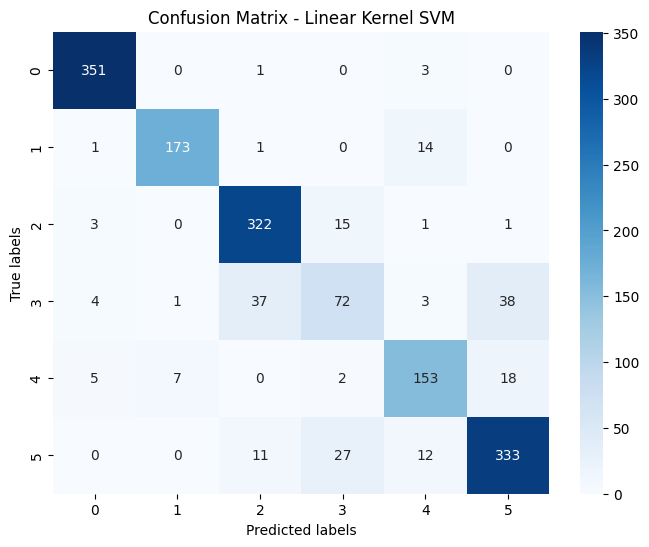

In [16]:
# TODO: Write your code here
svc_linear = SVC(kernel='linear')
svc_linear.fit(complete_X_train, complete_y_train)

y_pred_linear = svc_linear.predict(complete_X_test)

accuracy_linear, balanced_accuracy_linear, confusion_mat_linear = evaluate(complete_y_test, y_pred_linear)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_linear, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Linear Kernel SVM')
plt.show()

### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part. 

Accuracy:  0.8912367930391547
Balanced Accuracy:  0.8678617390048845
Confusion Matrix:
 [[351   1   2   0   1   0]
 [  0 181   0   1   6   1]
 [  3   1 325   7   1   5]
 [  3   1  37  90   2  22]
 [  3   2   1   1 164  14]
 [  0   1  11  41   7 323]]


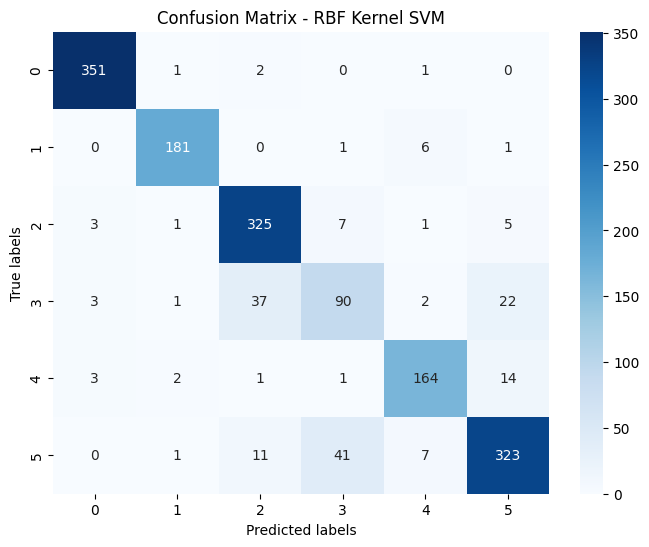

In [20]:
# TODO: Write your code here
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(complete_X_train, complete_y_train)
y_pred_rbf = svc_rbf.predict(complete_X_test)
accuracy_rbf, balanced_accuracy_rbf, confusion_mat_rbf = evaluate(complete_y_test, y_pred_rbf)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_rbf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - RBF Kernel SVM')
plt.show()

### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.8477315102548166
Balanced Accuracy:  0.8191602351764184
Confusion Matrix:
 [[353   0   1   0   1   0]
 [  3 175   1   3   5   2]
 [  5   0 310  21   0   6]
 [ 11   0  30  93   0  21]
 [ 25   2   0  10 128  20]
 [  2   1   4  68   3 305]]


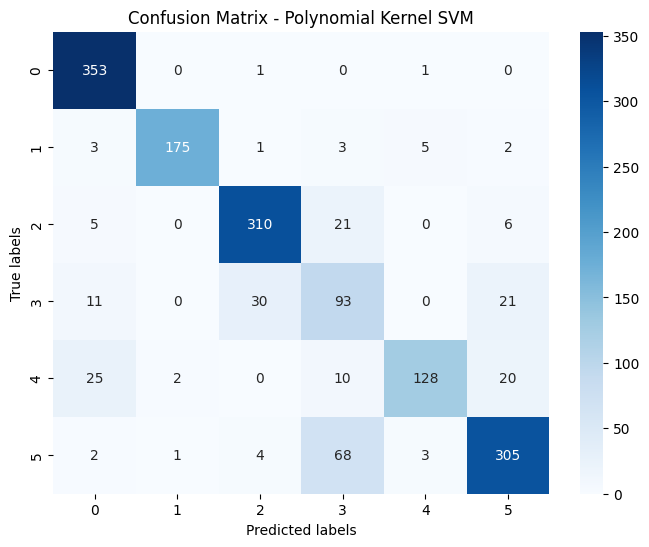

In [26]:
# TODO: Write your code here
svc_poly = SVC(kernel='poly', degree=3)
svc_poly.fit(complete_X_train, complete_y_train)
y_pred_poly = svc_poly.predict(complete_X_test)
accuracy_poly, balanced_accuracy_poly, confusion_mat_poly = evaluate(complete_y_test, y_pred_poly)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_poly, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Polynomial Kernel SVM')
plt.show()

### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts. 

Accuracy:  0.723430702299565
Balanced Accuracy:  0.678944902894234
Confusion Matrix:
 [[293   5  16   0  41   0]
 [ 25 156   0   2   6   0]
 [  2   0 306  30   3   1]
 [  4   1  39  50  16  45]
 [ 21  28   6  27  96   7]
 [  0   1  11  53  55 263]]


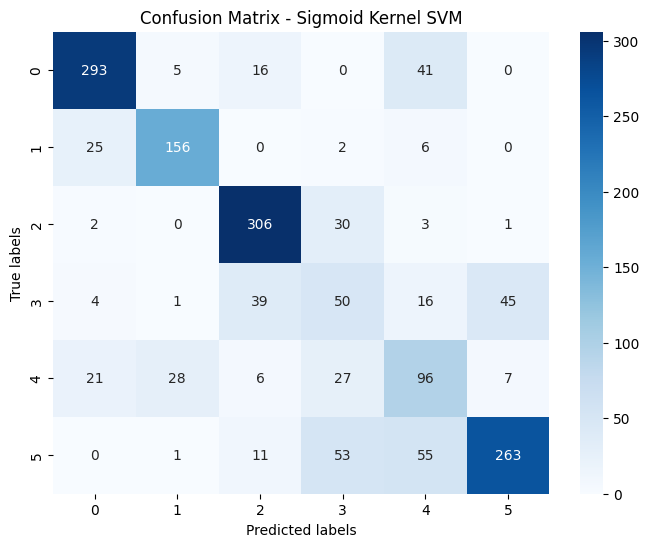

In [22]:
# TODO: Write your code here
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(complete_X_train, complete_y_train)
y_pred_sigmoid = svc_sigmoid.predict(complete_X_test)
accuracy_sigmoid, balanced_accuracy_sigmoid, confusion_mat_sigmoid = evaluate(complete_y_test, y_pred_sigmoid)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_sigmoid, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Sigmoid Kernel SVM')
plt.show()

Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one? 

`TODO: Write Here`

1. Linear Kernel:
    
    Advantages:
    - Easy to implement
    - Works well with a lot of features (high-dimentional data)
    - Works well when data is linearly seperable
    
    Disadvantages:
    - Bad performance when decision boundary is highly non-linear
    - Limited in handling non-linear relationships between features


2. Gaussian RBF Kernel:
    
    Advantages:
    - Good performance even when decision boundary is highly non-linear
    - Highly flexible and capable of capturing non-linear relationships
    - useful when there is no prior knowledge about the distribution of data

    Disadvantages:
    - Might overfit on the training data, especially if gamma parameter is not fine-tuned.
    - Computationally expensive for large data sets

3. Polynomial Kernel:
    
    Advantages:
    - More computationally efficient in comparison to Gaussian RBF Kernel
    - Capable of capturing non-linear relationships in data by using polynomial features

    Disadvantages:
    - Might overfit on the training data, especially with high value of degree parameter.
    - High sensitivity to choice of parameters, e.g. degree parameter

4. Sigmoid Kernel:
    
    Advantages:
    - Suitable for problems where data distribution is not well-understood
    - Mostly computationally efficient
    - Capable of capturing non-linear relationships in data

    Disadvantages:
    - Might overfit on the training data with not tuned parameters
    - High sensitivity to choice of hyperparameters, e.g. kernel coefficients and bias
    